In [81]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.model_selection import KFold
from tensorflow.keras import layers
from keras.layers import Input, Dense, Flatten, LSTM, MaxPooling2D, Conv2D
from keras.optimizers import Adam
import cv2
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import figure as fig

In [8]:
#function definition to retrieve the web scraped images
labels = ['play_card', 'token']
img_size = 366
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

In [9]:
#Pre process of the dataset, up-sample and organize the data into test and training sets

train = get_training_data('./train')
test = get_training_data('./test')

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.015),
    layers.RandomContrast([.15,.2]),
    layers.RandomZoom(.025),
    layers.RandomBrightness([.01,.45])
])

data_augmentation2 = tf.keras.Sequential([
    layers.RandomContrast([.175,.35]),
    layers.RandomBrightness([.09,.45]),
    layers.RandomTranslation(.01,.1)
])


x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

counter =0

for feature, label in train:
    if label == 1:
        augmented_image = data_augmentation(feature)
        x_train.append(augmented_image)
        x_val.append(augmented_image)
        y_train.append(label)
        y_val.append(label)
        
        augmented_image = data_augmentation2(feature)
        x_train.append(augmented_image)
        x_val.append(augmented_image)
        y_train.append(label)
        y_val.append(label)
        
        x_train.append(feature) 
        x_val.append(feature)
        y_train.append(label)
        y_val.append(label)
    else:
        if counter%5 ==0:
            augmented_image = data_augmentation(feature)
            x_train.append(augmented_image)
            x_val.append(augmented_image)
            y_train.append(label)
            y_val.append(label)
            
            x_train.append(feature)
            x_val.append(feature)
            y_train.append(label)
            y_val.append(label)
        elif counter%9 ==0:
            augmented_image = data_augmentation2(feature)
            x_train.append(augmented_image)
            x_val.append(augmented_image)
            y_train.append(label)
            y_val.append(label)
            
            x_train.append(feature)
            x_val.append(feature)
            y_train.append(label)
            y_val.append(label)
        else:
            x_train.append(feature)
            x_val.append(feature)
            y_train.append(label)
            y_val.append(label)
            
    counter +=1
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255


print("x_train shape:", x_train.shape)
print("x_val shape:",x_val.shape)
print("x_test shape:", x_test.shape)
print()
print("y_train length:", len(y_train))
print("y_train count 0 ",y_train.count(0))
print("y_train count 1 ",y_train.count(1))
print("y_val length:",len(y_val))
print("y_val count 0 ",y_val.count(0))
print("y_val count 1 ",y_val.count(1))
print("y_test length:",len(y_test))
print("y_test count 0 ",y_test.count(0))
print("y_test count 1 ",y_test.count(1))

x_train shape: (2849, 366, 366, 3)
x_val shape: (2849, 366, 366, 3)
x_test shape: (1222, 366, 366, 3)

y_train length: 2849
y_train count 0  1487
y_train count 1  1362
y_val length: 2849
y_val count 0  1487
y_val count 1  1362
y_test length: 1222
y_test count 0  978
y_test count 1  244


In [10]:
imported_model= tf.keras.applications.ResNet50(include_top=False,
pooling='avg',classes=2,
weights='imagenet', input_shape=(366,366,3))

for layer in imported_model.layers:
    layer.trainable=False

In [11]:
dnn_model = Sequential()
dnn_model.add(imported_model)
dnn_model.add(Flatten())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))
dnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
x_train_np = np.array(x_train)
y_train_np= np.array(y_train)
x_val_np = np.array(x_val)
y_val_np = np.array(y_val)

history = dnn_model.fit(
x_train_np, y_train_np,
validation_data=(x_val_np,y_val_np),
epochs=5)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 708s 8s/step - accuracy: 0.6439 - loss: 0.9293 - val_accuracy: 0.8452 - val_loss: 0.3808
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 584s 7s/step - accuracy: 0.8746 - loss: 0.3257 - val_accuracy: 0.9396 - val_loss: 0.2094
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 575s 6s/step - accuracy: 0.9353 - loss: 0.2130 - val_accuracy: 0.9509 - val_loss: 0.1559
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 579s 6s/step - accuracy: 0.9283 - loss: 0.1896 - val_accuracy: 0.9168 - val_loss: 0.2042
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 640s 7s/step - accuracy: 0.9327 - loss: 0.1717 - val_accuracy: 0.9572 - val_loss: 0.1127


In [ ]:
x_train_np.shape

In [ ]:
len(y_train)

In [7]:
prediction = dnn_model.predict(x_test)
predictions = (prediction > 0.5)*1 # convert probabilities to binary output


39/39 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step


In [8]:
accuracy_score(y_test, predictions)

0.8919803600654664

In [13]:
dnn_model.save('./resnet_model.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [5]:
resnet_model = keras.models.load_model('./resnet_model.keras')

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_544>'],)
  • kwargs=<class 'inspect._empty'>

In [15]:
dnn_model.save('./image_classification_resnet.keras')

In [16]:
cm = confusion_matrix(y_test, predictions)

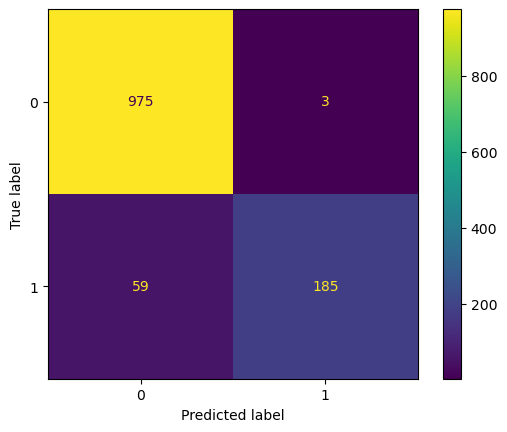

In [17]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1]).plot()
plt.show()

In [18]:
fpr, tpr, thresholds = roc_curve(y_test,predictions)

In [19]:
roc_auc = auc(fpr, tpr)

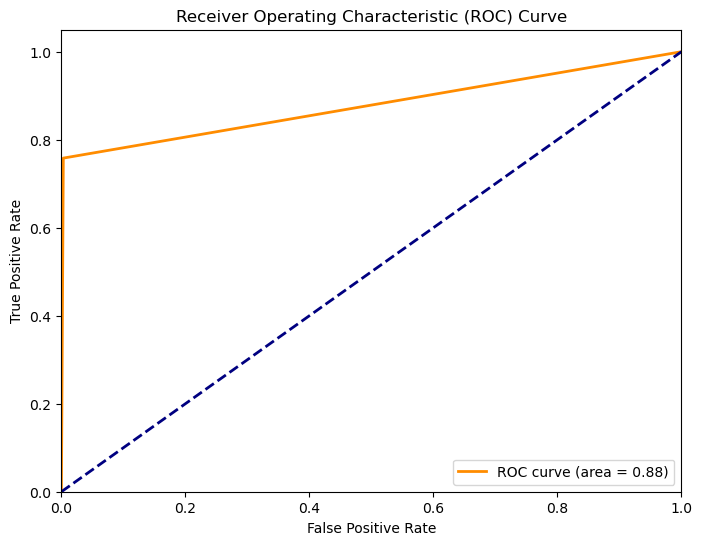

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
inputshape = (366,366,3)
baseModel = tf.keras.applications.VGG16(input_shape = inputshape, include_top=False, weights = 'imagenet')
model = tf.keras.models.Sequential()
model.add(baseModel)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.layers[0].trainable = False
model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [17]:
x_train_np = np.array(x_train)
x_val_np = np.array(x_train)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)

In [18]:
model.fit(x_train_np, y_train_np, validation_data = (x_val_np,y_val_np), epochs = 1)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1888s 21s/step - accuracy: 0.8725 - loss: 0.3650 - val_accuracy: 0.9975 - val_loss: 0.0078


In [19]:
def new_predict():    
    x = input("Choose a number between 1 - 184: ")
    classes = ['play_card', 'token']
    
    img_list =[]
    img = cv2.resize(cv2.imread('./new_predict/image_'+str(x)+'_pred_img.jpg'),(366,366))
#     img = np.array()
    
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.035),
        layers.RandomContrast([.25,.45]),
        layers.RandomZoom(.08),
        layers.RandomBrightness([.065,.45]),
        layers.RandomTranslation(.01,.2)])
    aug_img = np.array(data_augmentation(img))
    img_list.append(img)
    img_list.append(aug_img)
    i = 0
    plt.subplot(1,2,1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image (resized)')
    plt.imshow(img)
    plt.tight_layout()
    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Augmented Image')
    plt.imshow(aug_img.astype('uint8'))
    plt.tight_layout()
    
    scaled_img = aug_img/255
    pred_img = np.expand_dims(scaled_img, axis=0)
    
    model_list=[]
    final_model = keras.models.load_model('image_classification_finalmodel.keras')
    imb_model = keras.models.load_model('image_classification_imbalancedmodel.keras')
#     vgg16_model = model
#     resnet_model = dnn_model
    model_list.append(final_model)
    model_list.append(imb_model)
    model_list.append(model)
    model_list.append(dnn_model)
    
    pred_list = []
    for m in model_list:
        prediction = m.predict(pred_img)
        pred_label = (prediction > 0.5)*1
        pred_list.append(int(pred_label))
    print("CNN model's prediction:", classes[pred_list[0]])
    print("Imbalanced model's prediction:", classes[pred_list[1]])
    print("Predefined model (VGG16) prediction:", classes[pred_list[2]])
    print("Predefined model (ResNet50) prediction:", classes[pred_list[3]])

Choose a number between 1 - 184: 66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
CNN model's prediction: token
Imbalanced model's prediction: token
Predefined model (VGG16) prediction: token
Predefined model (ResNet50) prediction: token


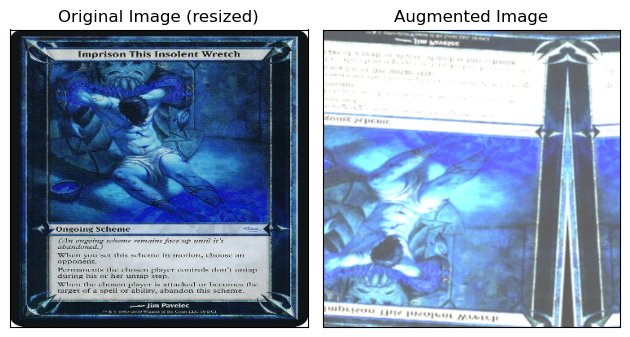

In [47]:
new_predict()

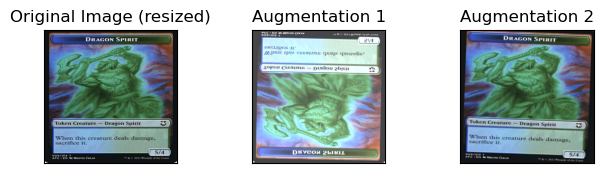

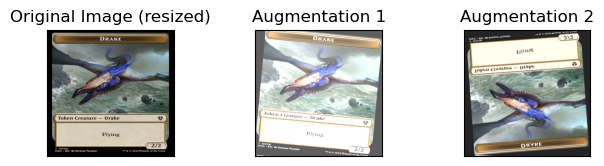

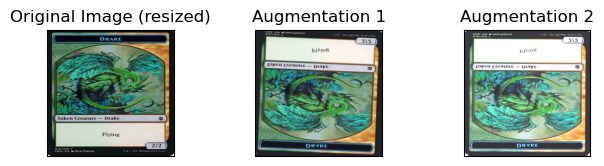

In [84]:
#view augmentation of token images
i = 0
for feature, label in train[1215:1218]:
    if label == 1:
        img = np.array(feature)/255
        data_augmentation = tf.keras.Sequential([
            layers.RandomFlip("vertical"),
            layers.RandomRotation(0.015),
            layers.RandomContrast([.15,.2]),
            layers.RandomZoom(.025),
            layers.RandomBrightness([.01,.45])
            ])

        data_augmentation2 = tf.keras.Sequential([
            layers.RandomContrast([.175,.35]),
            layers.RandomBrightness([.09,.45]),
            layers.RandomTranslation(.01,.1)])

        augmented1 = data_augmentation(feature).numpy()
        augmented2 = data_augmentation(feature).numpy()
        
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title('Original Image (resized)')
        plt.imshow(feature)
        plt.tight_layout()
        i += 1
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title('Augmentation 1')
        plt.imshow(augmented1.astype('uint8'))
        plt.tight_layout()
        i += 1
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title('Augmentation 2')
        plt.imshow(augmented2.astype('uint8'))
        plt.tight_layout() 
        i += 1
        plt.show()
            
        